# Yaw Robustness Analysis

This notebook generates:
1. Success Rate vs Yaw Noise bar plot
2. Break Rate vs Yaw Noise bar plot

In [1]:
# ============================================================
# BLOCK 1: IMPORTS & CONSTANTS
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# WandB Configuration
ENTITY = "hur"
PROJECT = "SG_Exps"

# Method Tags (PLACEHOLDER - update these)
METHOD_TAGS = {
    #"Pose(15deg)": "",        # Green
    #"Hybrid-Basic(15deg)": "", # Orange
    #"MATCH(15deg)": "",       # Blue
    "Pose(3deg)": "pose_hex_state-std:2026-01-26_18:36",       # Purple
    "MATCH(3deg)": "MATCH_hex_state-std:2026-01-26_17:33",
    #"Hybrid-Basic(3deg)":"",
}

# Method Colors - set colors for each method here
""" THE COLORS KEY SHOULD NOT BE CHANGED FOR ANY REASON WITHOUT USER PERMISSION DO NOT OVERWRITE!!!"""
COLORS = {
    "Pose(15deg)": "#2ca02c",        # Green
    "Hybrid-Basic(15deg)": "#ff7f0e", # Orange
    "MATCH(15deg)": "#1f77b4",       # Blue
    "Pose(3deg)": "#781fb4",       # Purple
    "MATCH(3deg)": "#b41f1f",
    "Hybrid-Basic(3deg)":"#b4aa1f",
}

# Evaluation Tags
TAG_EVAL_PERFORMANCE = "eval_performance"
TAG_EVAL_YAW = "eval_yaw"

# Yaw Level Mapping: display label -> metric range string
# NOTE: The 0deg range has a leading space in wandb: " 0deg-15deg"
YAW_LEVELS = {
    "15deg": " 0deg-15deg",
    "30deg": "15deg-30deg",
    "45deg": "30deg-45deg",
    "60deg": "45deg-60deg",
}

# Metrics
METRIC_SUCCESS = "num_successful_completions"
METRIC_BREAKS = "num_breaks"
METRIC_TOTAL = "total_episodes"

In [2]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

def get_best_checkpoint_per_run(api, method_tag):
    """Find the best checkpoint for each run with the given method tag."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    best_checkpoints = {}
    for run in runs:
        history = run.history()
        if history.empty:
            print(f"Warning: Run {run.name} has no history data")
            continue
        
        # Calculate score: successes - breaks
        history["score"] = history[f"Eval_Core/{METRIC_SUCCESS}"] - history[f"Eval_Core/{METRIC_BREAKS}"]
        best_idx = history["score"].idxmax()
        best_step = int(history.loc[best_idx, "total_steps"])
        
        best_checkpoints[run.id] = {
            "run_name": run.name,
            "best_step": best_step,
            "score": history.loc[best_idx, "score"],
        }
        print(f"  {run.name}: best checkpoint at step {best_step} (score: {history.loc[best_idx, 'score']:.0f})")
    
    return best_checkpoints

# Get best checkpoints for each method
api = wandb.Api()
best_checkpoints_by_method = {}

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{method_name} ({method_tag}):")
    best_checkpoints_by_method[method_name] = get_best_checkpoint_per_run(api, method_tag)

wandb: Currently logged in as: robonuke (hur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Pose(3deg) (pose_hex_state-std:2026-01-26_18:36):
  Eval_performance_pose_hex(1mm)_state-std_f(15)_0: best checkpoint at step 1804800 (score: 100)
  Eval_performance_pose_hex(1mm)_state-std_f(15)_1: best checkpoint at step 2265600 (score: 99)
  Eval_performance_pose_hex(1mm)_state-std_f(15)_2: best checkpoint at step 2995200 (score: 99)
  Eval_performance_pose_hex(1mm)_state-std_f(15)_4: best checkpoint at step 2419200 (score: 100)
  Eval_performance_pose_hex(1mm)_state-std_f(15)_3: best checkpoint at step 2764800 (score: 97)

MATCH(3deg) (MATCH_hex_state-std:2026-01-26_17:33):
  Eval_performance_MATCH_hex(1mm)_state-std_f(15)_0: best checkpoint at step 2841600 (score: 87)
  Eval_performance_MATCH_hex(1mm)_state-std_f(15)_1: best checkpoint at step 2803200 (score: 92)
  Eval_performance_MATCH_hex(1mm)_state-std_f(15)_2: best checkpoint at step 2995200 (score: 98)
  Eval_performance_MATCH_hex(1mm)_state-std_f(15)_3: best checkpoint at step 2496000 (score: 96)
  Eval_performance_MATCH_h

In [3]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

def download_eval_yaw_data(api, method_tag, best_checkpoints):
    """Download eval_yaw data for best checkpoints across all yaw levels."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_YAW}]}
    )

    # Build lookup by agent number from best_checkpoints
    checkpoint_by_agent = {}
    for run_id, info in best_checkpoints.items():
        agent_num = info["run_name"].rsplit("_", 1)[-1]
        checkpoint_by_agent[agent_num] = info["best_step"]

    data = []
    for run in runs:
        # Extract agent number from run name
        agent_num = run.name.rsplit("_", 1)[-1]

        if agent_num not in checkpoint_by_agent:
            print(f"Warning: No matching performance run for agent {agent_num} ({run.name})")
            continue

        best_step = checkpoint_by_agent[agent_num]
        history = run.history()
        
        if best_step not in history["total_steps"].values:
            print(f"Warning: Checkpoint {best_step} not found in {run.name}")
            continue
        
        row = history[history["total_steps"] == best_step].iloc[0]
        
        for yaw_label, yaw_range in YAW_LEVELS.items():
            prefix = f"Yaw_Eval({yaw_range})_Core"
            data.append({
                "run_id": run.id,
                "run_name": run.name,
                "checkpoint": best_step,
                "yaw_level": yaw_label,
                "success": row[f"{prefix}/{METRIC_SUCCESS}"],
                "breaks": row[f"{prefix}/{METRIC_BREAKS}"],
                "total": row[f"{prefix}/{METRIC_TOTAL}"],
            })
    
    return pd.DataFrame(data)

# Download all data
yaw_data = {}

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\nDownloading data for {method_name}...")
    yaw_data[method_name] = download_eval_yaw_data(
        api, method_tag, best_checkpoints_by_method[method_name]
    )

# Print summary
print("\n" + "="*60)
print("YAW DATA SUMMARY")
print("="*60)
for method_name, df in yaw_data.items():
    print(f"\n{method_name}:")
    for yaw_label in YAW_LEVELS.keys():
        subset = df[df["yaw_level"] == yaw_label]
        if not subset.empty:
            total = subset["total"].sum()
            success_rate = 100 * subset["success"].sum() / total
            break_rate = 100 * subset["breaks"].sum() / total
            print(f"  {yaw_label}: Success={success_rate:.1f}%, Break={break_rate:.1f}%")




YAW DATA SUMMARY

Pose(3deg):
  15deg: Success=22.2%, Break=1.2%
  30deg: Success=0.0%, Break=1.6%
  45deg: Success=0.0%, Break=1.6%
  60deg: Success=0.0%, Break=3.0%

MATCH(3deg):
  15deg: Success=21.0%, Break=2.4%
  30deg: Success=0.0%, Break=5.4%
  45deg: Success=0.0%, Break=5.8%
  60deg: Success=0.0%, Break=7.6%


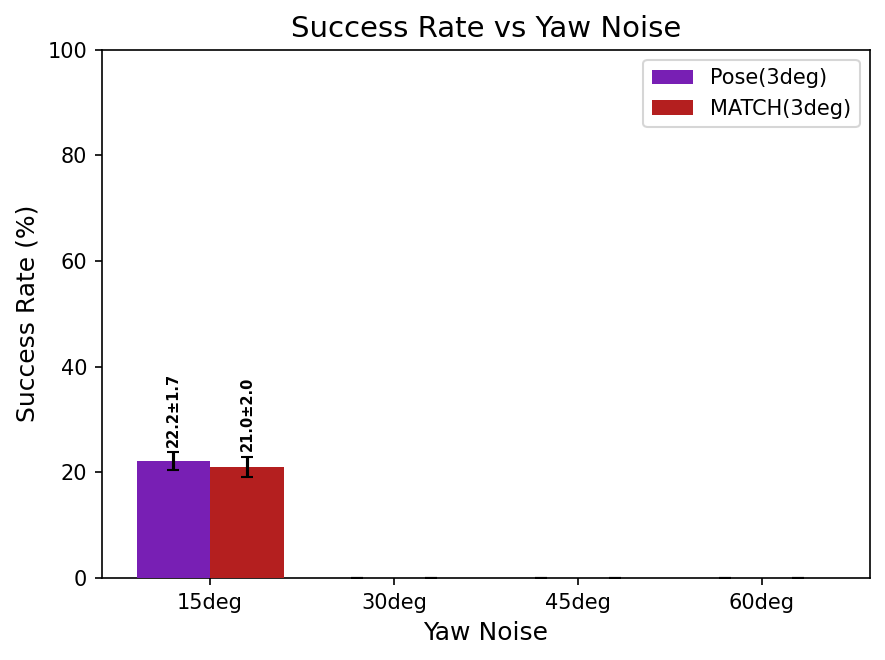

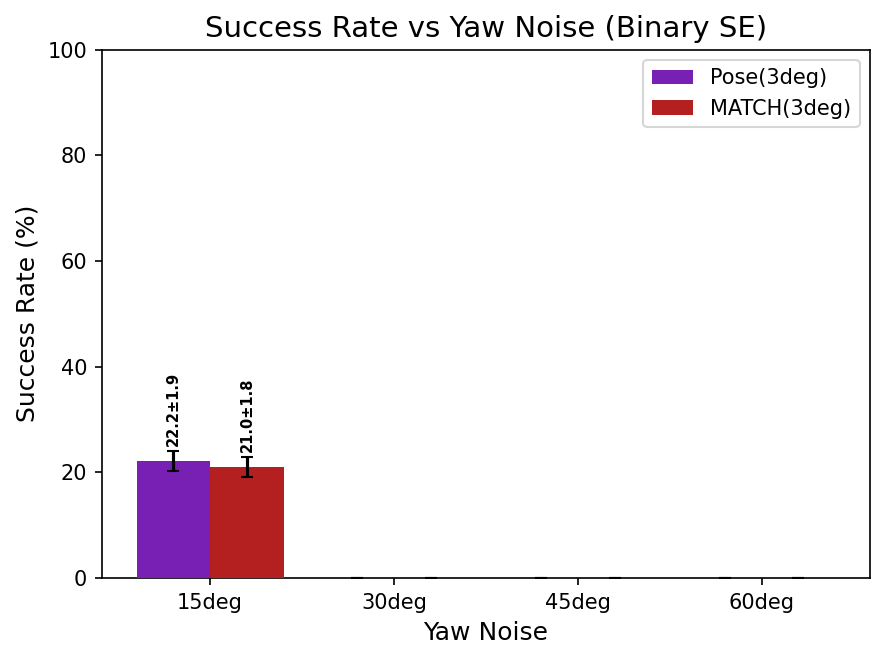

In [4]:
# ============================================================
# BLOCK 4: SUCCESS RATE VS YAW NOISE - BAR PLOT
# ============================================================

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all

# Plot Constants
FIGSIZE = (6, 4.5)
DPI = 150

# GROUP_WIDTH is the total width allocated to bars in each group (0.8 leaves some spacing)
GROUP_WIDTH = 0.8

# Font sizes
FONT_TITLE = 14
FONT_AXIS_LABEL = 12
FONT_TICK = 10
FONT_LEGEND = 10
FONT_BAR_LABEL = 7

# Axis configuration
Y_LIM = (0, 100)
Y_TICKS = [0, 20, 40, 60, 80, 100]

# Labels
TITLE = "Success Rate vs Yaw Noise"
TITLE_BINARY_SE = "Success Rate vs Yaw Noise (Binary SE)"
X_LABEL = "Yaw Noise"
Y_LABEL = "Success Rate (%)"

# ============================================================

def get_method_color(method_name):
    """Get color for a method."""
    if method_name in COLORS:
        return COLORS[method_name]
    raise ValueError(f"No color defined for method '{method_name}'. Add it to the COLORS dict in Block 1.")

def filter_top_n_runs(df, best_checkpoints, top_n):
    """Filter dataframe to only include top N runs by score."""
    if top_n is None or len(best_checkpoints) <= top_n:
        return df
    sorted_runs = sorted(best_checkpoints.items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_names = {info["run_name"] for _, info in sorted_runs[:top_n]}
    top_agent_nums = {name.rsplit("_", 1)[-1] for name in top_run_names}
    return df[df["run_name"].apply(lambda x: x.rsplit("_", 1)[-1] in top_agent_nums)]

def compute_binary_se(df, level_labels, level_col, metric="success"):
    """Compute binary standard error: sqrt(p*(1-p)/n) where p is pooled rate."""
    means = []
    binary_ses = []
    
    for label in level_labels:
        subset = df[df[level_col] == label]
        if not subset.empty:
            total_successes = subset[metric].sum()
            total_episodes = subset["total"].sum()
            p = total_successes / total_episodes
            mean_pct = p * 100
            se = np.sqrt(p * (1 - p) / total_episodes) * 100
            means.append(mean_pct)
            binary_ses.append(se)
        else:
            means.append(0)
            binary_ses.append(0)
    
    errors_lower = [min(se, mean) for mean, se in zip(means, binary_ses)]
    errors_upper = [min(se, 100 - mean) for mean, se in zip(means, binary_ses)]
    
    return means, binary_ses, errors_lower, errors_upper

yaw_labels = list(YAW_LEVELS.keys())
x = np.arange(len(yaw_labels))
method_names = list(METHOD_TAGS.keys())

n_methods = len(method_names)
BAR_WIDTH = GROUP_WIDTH / n_methods

# ============================================================
# PLOT 1: Success Rate with 95% CI (per-seed variation)
# ============================================================
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

for i, method_name in enumerate(method_names):
    df = yaw_data[method_name]
    df = filter_top_n_runs(df, best_checkpoints_by_method[method_name], TOP_N_POLICIES)
    means = []
    cis = []
    errors_lower = []
    errors_upper = []
    for yaw_label in yaw_labels:
        subset = df[df["yaw_level"] == yaw_label]
        if not subset.empty:
            subset = subset.copy()
            subset["success_rate"] = 100 * subset["success"] / subset["total"]
            mean = subset["success_rate"].mean()
            std = subset["success_rate"].std()
            n_seeds = len(subset)
            sem = std / np.sqrt(n_seeds)
            ci = 1.96 * sem
            errors_lower.append(min(ci, mean - 0))
            errors_upper.append(min(ci, 100 - mean))
            means.append(mean)
            cis.append(ci)
        else:
            means.append(0)
            cis.append(0)
            errors_lower.append(0)
            errors_upper.append(0)
    
    offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
    bars = ax.bar(x + offset, means, BAR_WIDTH, label=method_name, color=get_method_color(method_name),
           yerr=[errors_lower, errors_upper], capsize=3, zorder=3)
    
    y_range = Y_LIM[1] - Y_LIM[0]
    label_height_estimate = y_range * 0.20

    for bar, mean, ci, err_lower, err_upper in zip(bars, means, cis, errors_lower, errors_upper):
        if mean > 0:
            space_inside = bar.get_height() - err_lower
            if space_inside > label_height_estimate + 2:
                label_y = bar.get_height() - err_lower - 1
                va = 'top'
            else:
                label_y = bar.get_height() + err_upper + 1
                va = 'bottom'

            ax.text(bar.get_x() + bar.get_width()/2, label_y,
                   f'{mean:.1f}\u00b1{ci:.1f}', ha='center', va=va,
                   rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')

ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_ylabel(Y_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_title(TITLE, fontsize=FONT_TITLE)
ax.set_xticks(x)
ax.set_xticklabels(yaw_labels, fontsize=FONT_TICK)
ax.set_ylim(Y_LIM)
ax.set_yticks(Y_TICKS)
ax.tick_params(axis='y', labelsize=FONT_TICK)
ax.legend(fontsize=FONT_LEGEND)

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 2: Success Rate with Binary SE
# ============================================================
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

for i, method_name in enumerate(method_names):
    df = yaw_data[method_name]
    df = filter_top_n_runs(df, best_checkpoints_by_method[method_name], TOP_N_POLICIES)
    
    means, binary_ses, errors_lower, errors_upper = compute_binary_se(df, yaw_labels, "yaw_level", "success")
    
    offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
    bars = ax.bar(x + offset, means, BAR_WIDTH, label=method_name, color=get_method_color(method_name),
           yerr=[errors_lower, errors_upper], capsize=3, zorder=3)
    
    y_range = Y_LIM[1] - Y_LIM[0]
    label_height_estimate = y_range * 0.20

    for bar, mean, se, err_lower, err_upper in zip(bars, means, binary_ses, errors_lower, errors_upper):
        if mean > 0:
            space_inside = bar.get_height() - err_lower
            if space_inside > label_height_estimate + 2:
                label_y = bar.get_height() - err_lower - 1
                va = 'top'
            else:
                label_y = bar.get_height() + err_upper + 1
                va = 'bottom'

            ax.text(bar.get_x() + bar.get_width()/2, label_y,
                   f'{mean:.1f}\u00b1{se:.1f}', ha='center', va=va,
                   rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')

ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_ylabel(Y_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_title(TITLE_BINARY_SE, fontsize=FONT_TITLE)
ax.set_xticks(x)
ax.set_xticklabels(yaw_labels, fontsize=FONT_TICK)
ax.set_ylim(Y_LIM)
ax.set_yticks(Y_TICKS)
ax.tick_params(axis='y', labelsize=FONT_TICK)
ax.legend(fontsize=FONT_LEGEND)

plt.tight_layout()
plt.show()

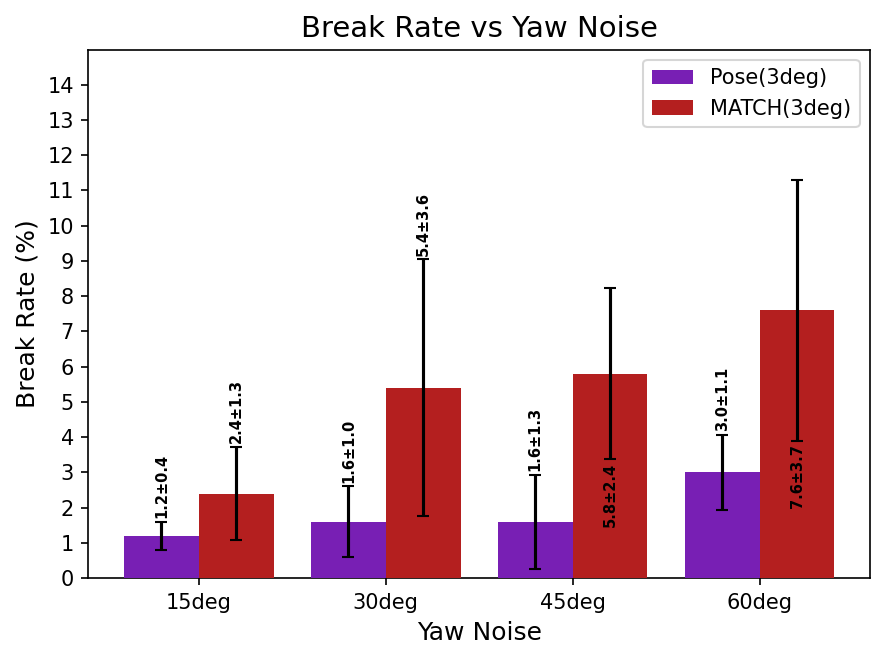

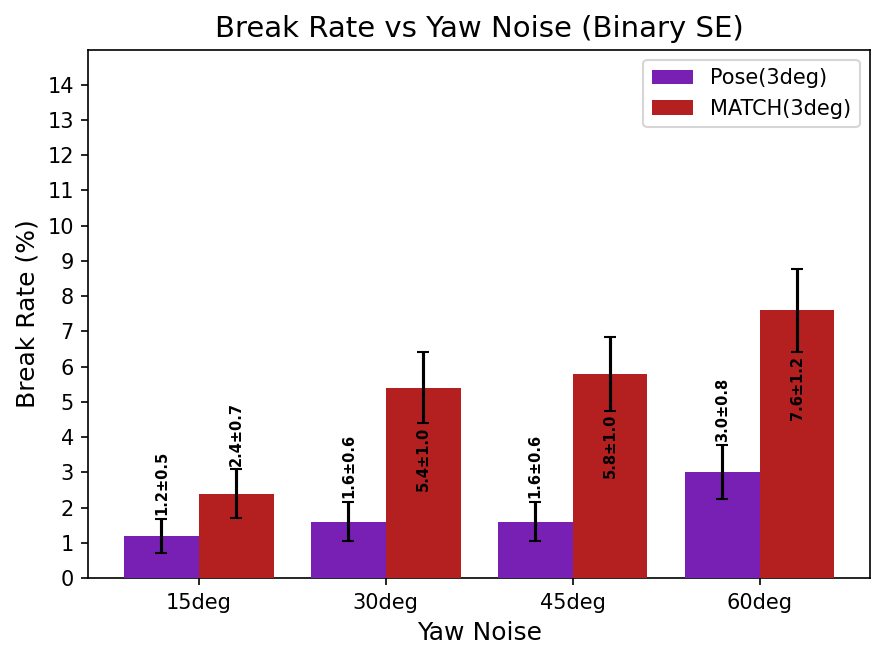

In [7]:
# ============================================================
# BLOCK 5: BREAK RATE VS YAW NOISE - BAR PLOT
# ============================================================

# Plot Constants
FIGSIZE = (6, 4.5)
DPI = 150

GROUP_WIDTH = 0.8

# Font sizes
FONT_TITLE = 14
FONT_AXIS_LABEL = 12
FONT_TICK = 10
FONT_LEGEND = 10
FONT_BAR_LABEL = 7

# Axis configuration
Y_LIM = (0, 15)
Y_TICKS = [i for i in range(Y_LIM[-1])]

# Labels
TITLE = "Break Rate vs Yaw Noise"
TITLE_BINARY_SE = "Break Rate vs Yaw Noise (Binary SE)"
X_LABEL = "Yaw Noise"
Y_LABEL = "Break Rate (%)"

# ============================================================

def filter_top_n_runs(df, best_checkpoints, top_n):
    """Filter dataframe to only include top N runs by score."""
    if top_n is None or len(best_checkpoints) <= top_n:
        return df
    sorted_runs = sorted(best_checkpoints.items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_names = {info["run_name"] for _, info in sorted_runs[:top_n]}
    top_agent_nums = {name.rsplit("_", 1)[-1] for name in top_run_names}
    return df[df["run_name"].apply(lambda x: x.rsplit("_", 1)[-1] in top_agent_nums)]

def compute_binary_se(df, level_labels, level_col, metric="success"):
    """Compute binary standard error: sqrt(p*(1-p)/n) where p is pooled rate."""
    means = []
    binary_ses = []
    
    for label in level_labels:
        subset = df[df[level_col] == label]
        if not subset.empty:
            total_successes = subset[metric].sum()
            total_episodes = subset["total"].sum()
            p = total_successes / total_episodes
            mean_pct = p * 100
            se = np.sqrt(p * (1 - p) / total_episodes) * 100
            means.append(mean_pct)
            binary_ses.append(se)
        else:
            means.append(0)
            binary_ses.append(0)
    
    errors_lower = [min(se, mean) for mean, se in zip(means, binary_ses)]
    errors_upper = [min(se, 100 - mean) for mean, se in zip(means, binary_ses)]
    
    return means, binary_ses, errors_lower, errors_upper

yaw_labels = list(YAW_LEVELS.keys())
x = np.arange(len(yaw_labels))
method_names = list(METHOD_TAGS.keys())

n_methods = len(method_names)
BAR_WIDTH = GROUP_WIDTH / n_methods

# ============================================================
# PLOT 1: Break Rate with 95% CI (per-seed variation)
# ============================================================
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

for i, method_name in enumerate(method_names):
    df = yaw_data[method_name]
    df = filter_top_n_runs(df, best_checkpoints_by_method[method_name], TOP_N_POLICIES)
    means = []
    cis = []
    errors_lower = []
    errors_upper = []
    for yaw_label in yaw_labels:
        subset = df[df["yaw_level"] == yaw_label]
        if not subset.empty:
            subset = subset.copy()
            subset["break_rate"] = 100 * subset["breaks"] / subset["total"]
            mean = subset["break_rate"].mean()
            std = subset["break_rate"].std()
            n_seeds = len(subset)
            sem = std / np.sqrt(n_seeds)
            ci = 1.96 * sem
            errors_lower.append(min(ci, mean - 0))
            errors_upper.append(min(ci, 100 - mean))
            means.append(mean)
            cis.append(ci)
        else:
            means.append(0)
            cis.append(0)
            errors_lower.append(0)
            errors_upper.append(0)
    
    offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
    bars = ax.bar(x + offset, means, BAR_WIDTH, label=method_name, color=get_method_color(method_name),
           yerr=[errors_lower, errors_upper], capsize=3, zorder=3)
    
    y_range = Y_LIM[1] - Y_LIM[0]
    label_height_estimate = y_range * 0.20

    for bar, mean, ci, err_lower, err_upper in zip(bars, means, cis, errors_lower, errors_upper):
        if mean > 0:
            space_inside = bar.get_height() - err_lower
            if space_inside > label_height_estimate + 0.2:
                label_y = bar.get_height() - err_lower - 0.1
                va = 'top'
            else:
                label_y = bar.get_height() + err_upper + 0.1
                va = 'bottom'

            ax.text(bar.get_x() + bar.get_width()/2, label_y,
                   f'{mean:.1f}\u00b1{ci:.1f}', ha='center', va=va,
                   rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')

ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_ylabel(Y_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_title(TITLE, fontsize=FONT_TITLE)
ax.set_xticks(x)
ax.set_xticklabels(yaw_labels, fontsize=FONT_TICK)
ax.set_ylim(Y_LIM)
ax.set_yticks(Y_TICKS)
ax.tick_params(axis='y', labelsize=FONT_TICK)
ax.legend(fontsize=FONT_LEGEND)

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 2: Break Rate with Binary SE
# ============================================================
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

for i, method_name in enumerate(method_names):
    df = yaw_data[method_name]
    df = filter_top_n_runs(df, best_checkpoints_by_method[method_name], TOP_N_POLICIES)
    
    means, binary_ses, errors_lower, errors_upper = compute_binary_se(df, yaw_labels, "yaw_level", "breaks")
    
    offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
    bars = ax.bar(x + offset, means, BAR_WIDTH, label=method_name, color=get_method_color(method_name),
           yerr=[errors_lower, errors_upper], capsize=3, zorder=3)
    
    y_range = Y_LIM[1] - Y_LIM[0]
    label_height_estimate = y_range * 0.20

    for bar, mean, se, err_lower, err_upper in zip(bars, means, binary_ses, errors_lower, errors_upper):
        if mean > 0:
            space_inside = bar.get_height() - err_lower
            if space_inside > label_height_estimate + 0.2:
                label_y = bar.get_height() - err_lower - 0.1
                va = 'top'
            else:
                label_y = bar.get_height() + err_upper + 0.1
                va = 'bottom'

            ax.text(bar.get_x() + bar.get_width()/2, label_y,
                   f'{mean:.1f}\u00b1{se:.1f}', ha='center', va=va,
                   rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')

ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_ylabel(Y_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_title(TITLE_BINARY_SE, fontsize=FONT_TITLE)
ax.set_xticks(x)
ax.set_xticklabels(yaw_labels, fontsize=FONT_TICK)
ax.set_ylim(Y_LIM)
ax.set_yticks(Y_TICKS)
ax.tick_params(axis='y', labelsize=FONT_TICK)
ax.legend(fontsize=FONT_LEGEND)

plt.tight_layout()
plt.show()